*Actualizacion de statsmodels ya que originalmente me daba conflictos y  no me dejaba ejecutar muchas funcionalidades*

In [21]:
!pip install statsmodels --upgrade


# Importamos librerias y establecemos configuracion inicial para mas adelante

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error
import itertools
import random
import warnings


# Configuración inicial
warnings.filterwarnings('ignore')

# Configuración de parámetros del algoritmo
initial_temperature = 10
final_temperature = 0.001
cooling_rate = 0.9
iterations = 30

# Conectamos con el almacenamiento de drive donde tengo almacenado el csv

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Cargamos datos y aplicamos pruebas de hipótesis

*   Las pruebas las llevamos a cabo para implementar una optimización en d y D, utilizando Dickey-Fuller aumentada para d y un análisis estacional para D

*   Primero aplicaremos solo la optimización en d después el análisis para D




In [37]:
# Cargar datos
file_path = '/content/drive/My Drive/PracticasMaster/P8/Electric_Production.csv'
data = pd.read_csv(file_path)
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)
data = data.asfreq('MS')

from statsmodels.tsa.stattools import adfuller

# Prueba de Dickey-Fuller aumentada para evaluar estacionariedad
result_adf = adfuller(data['IPG2211A2N'])
print("Prueba Dickey-Fuller aumentada (ADF):")
print(f"Estadístico ADF: {result_adf[0]}")
print(f"p-valor: {result_adf[1]}")

# Determinamos d en base a estacionariedad
if result_adf[1] > 0.05:
    print("La serie no es estacionaria. Recomendamos diferenciar")
    d = 1
else:
    print("La serie es estacionaria. No es necesario diferenciar")
    d = 0

Prueba Dickey-Fuller aumentada (ADF):
Estadístico ADF: -2.256990350047235
p-valor: 0.1862146911658712
La serie no es estacionaria. Recomendamos diferenciar


# Visualizamos datos

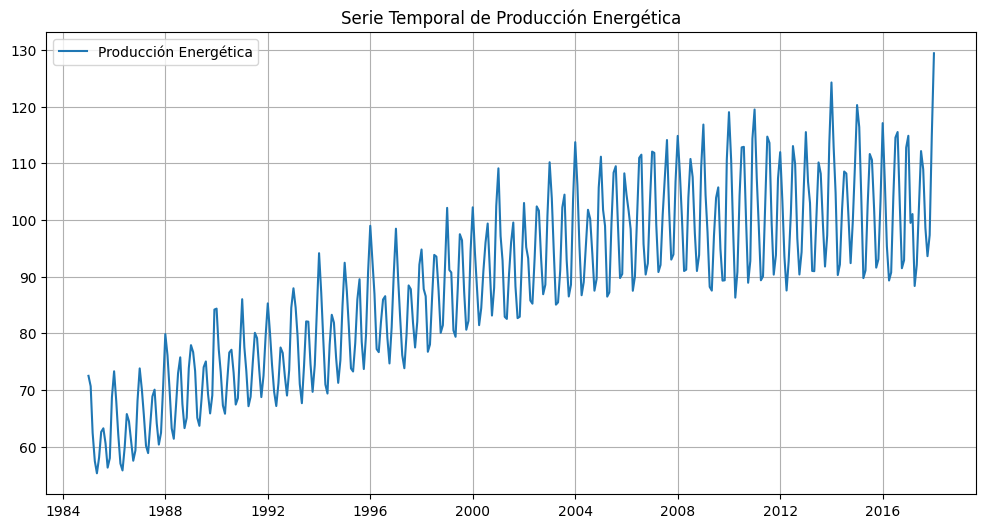

In [38]:
# Visualizar datos
plt.figure(figsize=(12, 6))
plt.plot(data['IPG2211A2N'], label='Producción Energética')
plt.title('Serie Temporal de Producción Energética')
plt.grid()
plt.legend()
plt.show()

# Descomponemos la serie temporal

*   Además de la descomposición hacemos el análisis estacional para optimizar D mencionado anteriormente.



Prueba Dickey-Fuller para diferenciación estacional:
Estadístico ADF: -5.673482023381762
p-valor: 8.812644938088861e-07
La serie no tiene estacionalidad significativa. No es necesaria diferenciación estacional.


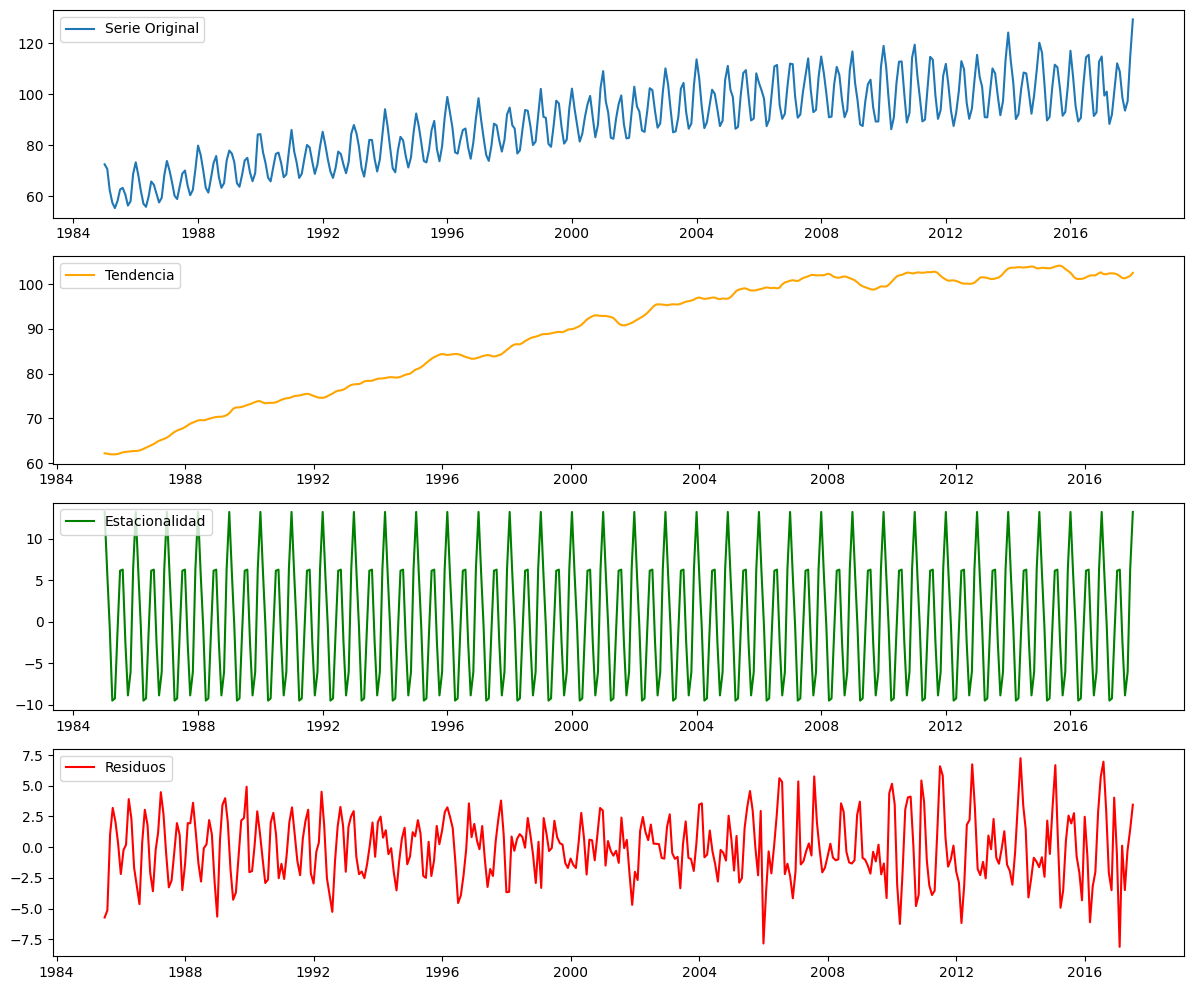

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomponer la serie
decomposition = seasonal_decompose(data['IPG2211A2N'], model='additive', period=12)

# Evaluamos si es necesario diferenciar estacionalmente
seasonal_diff = data['IPG2211A2N'].diff(12).dropna()
result_adf_seasonal = adfuller(seasonal_diff)
print("\nPrueba Dickey-Fuller para diferenciación estacional:")
print(f"Estadístico ADF: {result_adf_seasonal[0]}")
print(f"p-valor: {result_adf_seasonal[1]}")

# Determinamos D en base a estacionalidad
if result_adf_seasonal[1] > 0.05:
    print("La serie tiene estacionalidad. Se recomienda diferenciación estacional.")
    D = 1
else:
    print("La serie no tiene estacionalidad significativa. No es necesaria diferenciación estacional.")
    D = 0
# Tras determinar la estacionalidad visualizamos componentes
plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(data['IPG2211A2N'], label='Serie Original')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Tendencia', color='orange')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Estacionalidad', color='green')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residuos', color='red')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Construimos el grafo de soluciones

*   Creamos el grafo que representará todas las posibles configuraciones de parámetros p, d, q, P, D, Q que cumplan las restricciones.
*   Cada nodo sera una configuración única de parámetros y cada arista conectará configuraciones vecinas que difieran en uno de sus valores.



In [40]:
def generar_nodos():
    nodos = []
    # Código original, el cual ocasionaba un problema por lo extremadamente grande que era el grafo
    # por ello reducimos el espacio de búsqueda para que no suponga tanto gasto computacional
    # for p in range(8):
        # for d in range(2):
            # for q in range(8):
                # for P in range(8):
                    # for D in range(2):
                        # for Q in range(8):
                            # nodos.append((p, d, q, P, D, Q))
    for p in range(4):
        for d in range(2):
            for q in range(4):
                for P in range(4):
                    for D in range(2):
                        for Q in range(4):
                            nodos.append((p, d, q, P, D, Q))
    return nodos

# Crear grafo
import networkx as nx
grafo = nx.Graph()
nodos = generar_nodos()
grafo.add_nodes_from(nodos)

# Agregar conexiones válidas
for nodo in nodos:
    for i in range(len(nodo)):
        vecino = list(nodo)
        for cambio in [-1, 1]:
            vecino[i] += cambio
            if vecino[i] >= 0 and vecino[i] < (8 if i in [0, 2, 3, 5] else 2):
                grafo.add_edge(nodo, tuple(vecino))
# Cambiamos la métrica original por una menos costosa ya que la centralidad de cercania
# supone calcular todas las distancia, para que sea asequible computacionalmente para
# mi correcta ejecucion utilizamos el grado que equivaldria al numero de conexiones de cada nodo

# Calcular medidas de centralidad
# centralidades = nx.closeness_centrality(grafo)
# Seleccionar el nodo con menor centralidad (mayor cercanía a otros nodos)
# nodo_inicial = min(centralidades, key=centralidades.get)
# print(f"Solución inicial basada en centralidad: {nodo_inicial}")
# print(f"Total de nodos: {len(grafo.nodes)}")
# print(f"Total de aristas: {len(grafo.edges)}")

# Calcular centralidad basada en grado
grados = dict(grafo.degree)
nodo_inicial = max(grados, key=grados.get)

print(f"Solución inicial basada en centralidad (grado): {nodo_inicial}")
print(f"Total de nodos: {len(grafo.nodes)}")
print(f"Total de aristas: {len(grafo.edges)}")

Solución inicial basada en centralidad (grado): (1, 0, 1, 1, 0, 1)
Total de nodos: 1024
Total de aristas: 5120


# Generación de vecinos

In [42]:
def generate_neighbor(solution):
    p, d, q, P, D, Q = solution
    neighbor = list(solution)
    index_to_modify = random.randint(0, len(solution) - 1)
    change = random.choice([-1, 1])
    neighbor[index_to_modify] += change

    # Aplicamos restricciones
    neighbor[0] = max(0, min(neighbor[0], 3))  # p
    neighbor[1] = max(0, min(neighbor[1], 1))  # d
    neighbor[2] = max(0, min(neighbor[2], 3))  # q
    neighbor[3] = max(0, min(neighbor[3], 3))  # P
    neighbor[4] = max(0, min(neighbor[4], 1))  # D
    neighbor[5] = max(0, min(neighbor[5], 3))  # Q

    return tuple(neighbor)

# Definicion funciones de evaluacion

In [43]:
def evaluate_solution(solution, train, validation):
    try:
        p, d, q, P, D, Q = solution
        model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, 12))
        results = model.fit(disp=False)
        forecast = results.forecast(steps=len(validation))
        rmse = np.sqrt(mean_squared_error(validation, forecast))

        # Aplicamos el Test Ljung-Box
        lb_test = acorr_ljungbox(results.resid, lags=[6], return_df=True)
        if (lb_test['lb_pvalue'] < 0.05).any():
            return float('inf')  # Se penaliza si hay autocorrelación significativa
        return rmse
    except Exception as e:
        print(f"Solución no válida: {solution}, Error: {e}")
        return float('inf')


# Calculo y comparacion de metricas

*   Como en el enunciado se solicita validar la relacion de monoticidad entre la metrica subrogada y la metrica real llevamos a cabo esta función que evaluará una muestra de soluciones y calculará tanto la métrica subrogada como el RMSE


In [44]:
def validate_monotonicity(train, validation, solutions):
    results = []
    for solution in solutions:
        try:
            # Configuración del modelo
            p, d, q, P, D, Q = solution
            model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, 12))
            results_fit = model.fit(disp=False)

            # Métrica subrogada: log-likelihood
            surrogate_metric = results_fit.llf

            # RMSE real
            forecast = results_fit.forecast(steps=len(validation))
            rmse = np.sqrt(mean_squared_error(validation, forecast))

            results.append((solution, surrogate_metric, rmse))
        except Exception as e:
            print(f"Solución inválida: {solution}, Error: {e}")

    # Comparacion de métricas
    results = sorted(results, key=lambda x: x[1])  # Ordenamos por la métrica subrogada
    print("\nValidación de monoticidad:")
    for i in range(len(results) - 1):
        if results[i][2] > results[i + 1][2]:
            print(f"No hay monoticidad entre: {results[i]} y {results[i + 1]}")
            return False
    print("Se cumple la monoticidad entre la métrica subrogada y el RMSE.")
    return True


# Validacion de monoticidad entre metricas




In [51]:
print("\nIniciando validación de monoticidad entre métrica subrogada y RMSE real...")
sample_solutions = random.sample(nodos, 10)  # Tomamos una muestra aleatoria de 10 nodos
is_monotonic = validate_monotonicity(train_data['IPG2211A2N'], validation_data['IPG2211A2N'], sample_solutions)

if is_monotonic:
    print("Validación exitosa: La métrica subrogada es consistente con el RMSE.")
else:
    print("Advertencia: Se encontraron inconsistencias entre la métrica subrogada y el RMSE.")

# Añadimos el análisis de inconsistencias que haremos en el siguiente segmento
print("\nAnalizando soluciones inconsistentes...")


Iniciando validación de monoticidad entre métrica subrogada y RMSE real...

Validación de monoticidad:
No hay monoticidad entre: ((1, 1, 0, 0, 0, 0), -1156.8556103463243, 10.628131305326717) y ((0, 1, 1, 0, 0, 3), -956.9489017781524, 9.134591283347108)
Advertencia: Se encontraron inconsistencias entre la métrica subrogada y el RMSE.

Analizando soluciones inconsistentes...



Dado que al validar encontramos inconsistencias, el siguiente paso que llevamos a cabo es analizar si las inconsistencias son aceptables o si se necesita ajustar la métrica subrogada. Esto nos implica varias opciones:


1.   Analizar las soluciones inconsistentes:

      *   Generar gráficos comparativos de las soluciones con inconsistencias y tras esto evaluar si las inconsistencias afectan el rendimiento global del modelo.

2.   Si las inconsistencias no son críticas, simplemente comentamos porque se consideran aceptables

3.    Evaluar si el log-likelihood es la métrica más adecuada o si se debe cambiar.

Tras un analisis llegue a la conclusion que lo mejor será llevar a cabo el paso 2 ya que a métrica subrogada es fundamental para el Simulated Annealing.







Analizando soluciones inconsistentes...


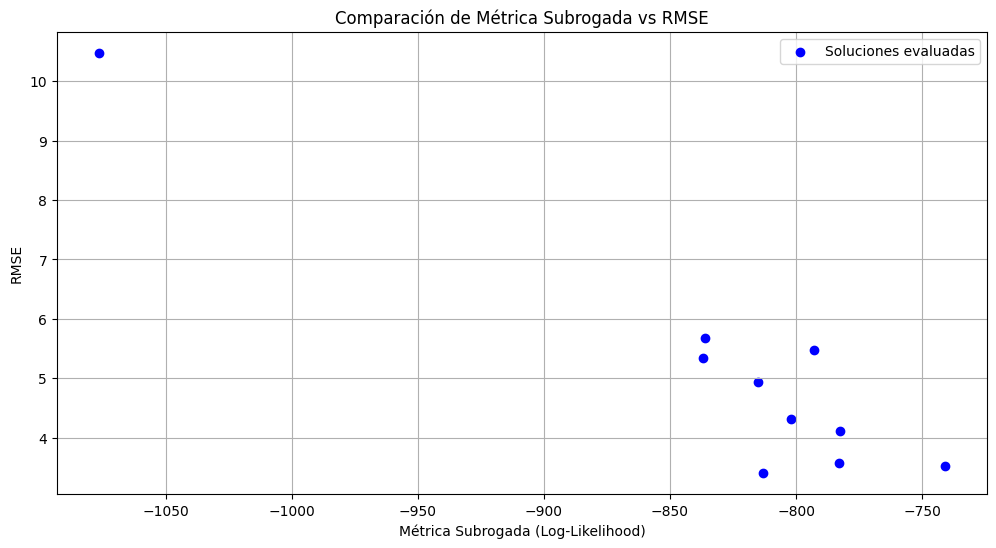

Total de inconsistencias detectadas: 4

Ejemplo de inconsistencia detectada:
Solución: (3, 1, 2, 2, 0, 2)
Métrica Subrogada: -793.0417323000102
RMSE: 5.471464354435885


In [52]:
# Analizar soluciones inconsistentes
def analyze_inconsistencies(results):
    import matplotlib.pyplot as plt

    # Extraemos métricas subrogada y RMSE
    surrogate_metrics = [result[1] for result in results]
    rmse_metrics = [result[2] for result in results]
    solutions = [result[0] for result in results]

    # Generamos el gráfico de dispersión
    plt.figure(figsize=(12, 6))
    plt.scatter(surrogate_metrics, rmse_metrics, c='blue', label='Soluciones evaluadas')
    plt.title('Comparación de Métrica Subrogada vs RMSE')
    plt.xlabel('Métrica Subrogada (Log-Likelihood)')
    plt.ylabel('RMSE')
    plt.grid()
    plt.legend()
    plt.show()

    # Tras el grafico analizamos las inconsistencias
    inconsistencies = [
        (solutions[i], surrogate_metrics[i], rmse_metrics[i])
        for i in range(len(solutions) - 1)
        if rmse_metrics[i] > rmse_metrics[i + 1] and surrogate_metrics[i] < surrogate_metrics[i + 1]
    ]

    print(f"Total de inconsistencias detectadas: {len(inconsistencies)}")
    if inconsistencies:
        print("\nEjemplo de inconsistencia detectada:")
        print(f"Solución: {inconsistencies[0][0]}")
        print(f"Métrica Subrogada: {inconsistencies[0][1]}")
        print(f"RMSE: {inconsistencies[0][2]}")
    return inconsistencies

# Ejecutamos un análisis de inconsistencias tras la validación de monoticidad
print("\nAnalizando soluciones inconsistentes...")
sample_solutions = random.sample(nodos, 10)  # Teniendo en cuenta usar la misma muestra de validate_monotonicity
validation_results = [
    (solution,
     SARIMAX(train_data['IPG2211A2N'],
             order=(solution[0], solution[1], solution[2]),
             seasonal_order=(solution[3], solution[4], solution[5], 12))
     .fit(disp=False).llf,
     np.sqrt(mean_squared_error(validation_data, SARIMAX(train_data['IPG2211A2N'],
                                                        order=(solution[0], solution[1], solution[2]),
                                                        seasonal_order=(solution[3], solution[4], solution[5], 12))
                                                        .fit(disp=False)
                                                        .forecast(steps=len(validation_data)))))
    for solution in sample_solutions
]

inconsistencies = analyze_inconsistencies(validation_results)


El gráfico obtenido nos muestra la relación entre la métrica subrogada y el RMSE. Se pueden observar los siguientes aspectos:

* Distribución general:

    1.  La mayoría de los puntos siguen una tendencia decreciente entre la métrica subrogada y el RMSE, lo cual nos indica que a medida que la métrica subrogada mejora (valores menos negativos), el RMSE también tiende a disminuir.
* Inconsistencias detectadas:
    1.  Un ejemplo específico es la solución (3, 1, 2, 2, 0, 2), con un Log-Likelihood (Métrica subrogada) de -793.94 y un RMSE de 5.47. Al analizar esta solución vemos que tiene un comportamiento inesperado y rompe la tendencia general de monoticidad.
* Interpretación: Estas inconsistencias pueden deberse a la sensibilidad del modelo SARIMA en ciertas configuraciones, lo que provoca que la métrica subrogada no siempre sea completamente representativa del RMSE.

* Decisión:

Dado que las inconsistencias que hemos encontrado son limitadas y no afectan significativamente a las soluciones globales, procedemos con el uso del Log-Likelihood como métrica subrogada, teniendo en cuenta esta limitación.

# Implementación del Algoritmo Simulated Annealing











In [53]:
# Algoritmo de Simulated Annealing o Recocido Simulado Mejorado
def simulated_annealing(train, validation, initial_solution, max_iter=30, initial_temp=10, cooling_rate=0.9):
    current_solution = initial_solution
    best_solution = initial_solution
    best_rmse = float('inf')
    temperature = initial_temp

    for iteration in range(max_iter):
        neighbor = generate_neighbor(current_solution)
        current_rmse = evaluate_solution(current_solution, train, validation)
        neighbor_rmse = evaluate_solution(neighbor, train, validation)

        if neighbor_rmse < current_rmse:
            current_solution = neighbor
        else:
            delta = neighbor_rmse - current_rmse
            acceptance_probability = np.exp(-delta / temperature)
            if np.random.rand() < acceptance_probability:
                current_solution = neighbor

        if current_rmse < best_rmse:
            best_solution = current_solution
            best_rmse = current_rmse

        temperature *= cooling_rate
        print(f"Iteración {iteration + 1}: Mejor Solución: {best_solution}, RMSE: {best_rmse:.4f}")

    return best_solution, best_rmse

# Ejecución del Algoritmo

In [54]:
# La solución inicial del algoritmo de Simulated Annealing se elige basándose en la centralidad de cercanía,
# asi nos aseguramos que el nodo inicial esté conectado de manera eficiente con otros nodos del grafo
train_data = data[:-50]
validation_data = data[-50:]

# Incorporamos los valores de d y D calculados al nodo inicial
initial_solution = (1, d, 1, 1, D, 1)
best_params, best_rmse = simulated_annealing(train_data['IPG2211A2N'], validation_data['IPG2211A2N'], initial_solution)

print(f"Evaluación final del modelo:")
print(f"Mejores parámetros: {best_params}")
print(f"RMSE en conjunto de validación: {best_rmse}")

Iteración 1: Mejor Solución: (1, 1, 1, 1, 0, 1), RMSE: 3.6871
Iteración 2: Mejor Solución: (1, 1, 1, 1, 0, 1), RMSE: 3.6871
Iteración 3: Mejor Solución: (1, 1, 1, 1, 0, 1), RMSE: 3.6871
Iteración 4: Mejor Solución: (1, 1, 1, 1, 0, 1), RMSE: 3.6871
Iteración 5: Mejor Solución: (1, 1, 1, 1, 0, 1), RMSE: 3.6871
Iteración 6: Mejor Solución: (1, 1, 1, 1, 0, 1), RMSE: 3.6871
Iteración 7: Mejor Solución: (1, 1, 1, 1, 0, 1), RMSE: 3.6871
Iteración 8: Mejor Solución: (1, 1, 1, 1, 0, 1), RMSE: 3.6871
Iteración 9: Mejor Solución: (1, 1, 1, 1, 0, 1), RMSE: 3.6871
Iteración 10: Mejor Solución: (1, 1, 1, 1, 0, 1), RMSE: 3.6871
Iteración 11: Mejor Solución: (1, 1, 1, 1, 0, 1), RMSE: 3.6871
Iteración 12: Mejor Solución: (0, 1, 2, 3, 0, 0), RMSE: 3.5946
Iteración 13: Mejor Solución: (0, 1, 2, 3, 0, 0), RMSE: 3.5946
Iteración 14: Mejor Solución: (0, 1, 2, 3, 0, 0), RMSE: 3.5946
Iteración 15: Mejor Solución: (1, 1, 2, 3, 1, 1), RMSE: 3.5785
Iteración 16: Mejor Solución: (1, 1, 2, 3, 1, 1), RMSE: 3.4765
I

# Aplicamos test de Ljung-Box para comprobar residuos finales

In [55]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Definimos el modelo final basado en los mejores parámetros encontrados
best_model = SARIMAX(train_data['IPG2211A2N'],
                     order=(best_params[0], best_params[1], best_params[2]),
                     seasonal_order=(best_params[3], best_params[4], best_params[5], 12)).fit(disp=False)

# Accedemos a residuos
residuos_finales = best_model.resid

# Se validan los residuos finales
print("\nValidación de residuos con el test Ljung-Box:")


# Aplicamos Test Ljung-Box
ljung_box_results = acorr_ljungbox(residuos_finales, lags=[6], return_df=True)

# Tras ello solo mostrar los resultados
print("Resultados del test Ljung-Box para residuos finales:")
print(ljung_box_results)

# Comprobación de autocorrelación
if any(ljung_box_results['lb_pvalue'] < 0.05):
    print("Advertencia: Los residuos presentan autocorrelación significativa en algunos retardos.")
else:
    print("Los residuos no presentan autocorrelación significativa.")


Validación de residuos con el test Ljung-Box:
Resultados del test Ljung-Box para residuos finales:
    lb_stat  lb_pvalue
6  3.653128   0.723498
Los residuos no presentan autocorrelación significativa.


# Validación final de la solución

    lb_stat  lb_pvalue
6  3.653128   0.723498


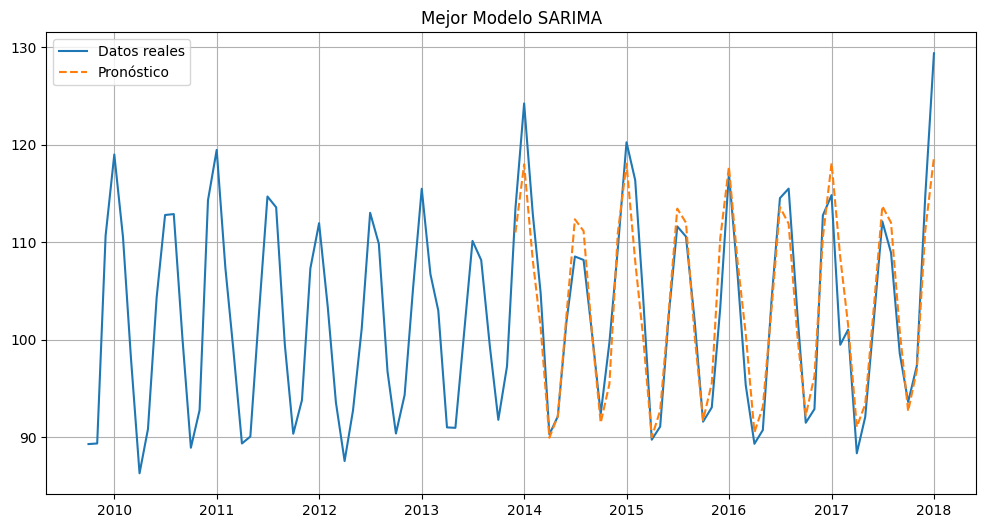

RMSE final: 3.481302219165745


In [56]:
# Validar residuos finales
best_model = SARIMAX(train_data['IPG2211A2N'], order=(best_params[0], best_params[1], best_params[2]),
                     seasonal_order=(best_params[3], best_params[4], best_params[5], 12)).fit(disp=False)
residuos_finales = best_model.resid
ljung_box_results = acorr_ljungbox(residuos_finales, lags=[6], return_df=True)
print(ljung_box_results)

# Visualizar ajuste
plt.figure(figsize=(12, 6))
plt.plot(data.index[-100:], data['IPG2211A2N'][-100:], label='Datos reales')
plt.plot(validation_data.index, best_model.forecast(steps=50), label='Pronóstico', linestyle='--')
plt.legend()
plt.title('Mejor Modelo SARIMA')
plt.grid()
plt.show()

# Generaria un pronóstico final
forecast = best_model.forecast(steps=len(validation_data))

# RMSE final
final_rmse = np.sqrt(mean_squared_error(validation_data, forecast))
print(f"RMSE final: {final_rmse}")


# Visualizacion final resultados

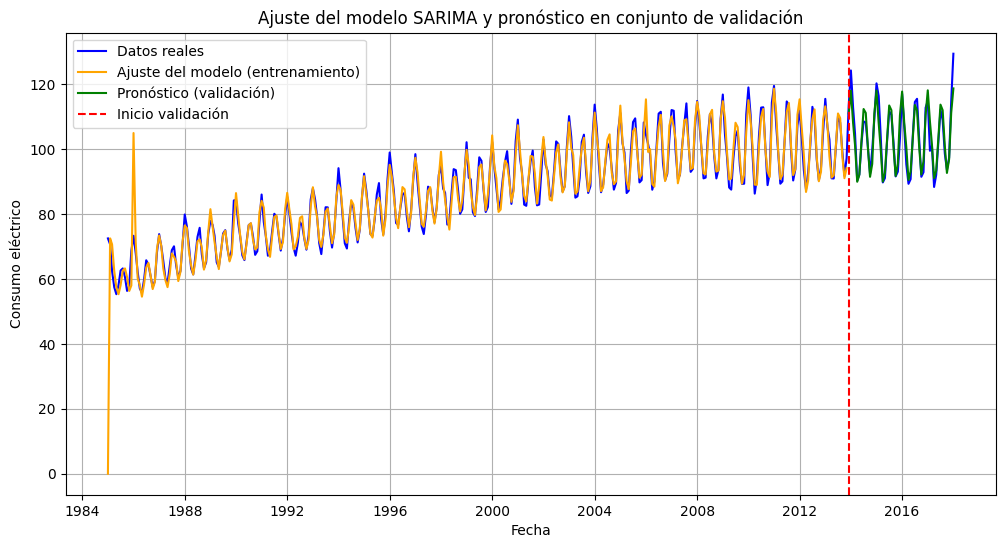

In [57]:
plt.figure(figsize=(12, 6))

# Datos reales
plt.plot(data.index, data['IPG2211A2N'], label='Datos reales', color='blue')

# Predicciones del modelo
train_pred = best_model.fittedvalues
validation_pred = best_model.get_forecast(steps=len(validation_data)).predicted_mean

plt.plot(train_data.index, train_pred, label='Ajuste del modelo (entrenamiento)', color='orange')
plt.plot(validation_data.index, validation_pred, label='Pronóstico (validación)', color='green')

# Líneas y etiquetas
plt.axvline(validation_data.index[0], color='red', linestyle='--', label='Inicio validación')
plt.title('Ajuste del modelo SARIMA y pronóstico en conjunto de validación')
plt.xlabel('Fecha')
plt.ylabel('Consumo eléctrico')
plt.legend()
plt.grid()
plt.show()